# Task latency investigations

## Setup

In [1]:
import re
import datetime
from math import log
import csv
import pprint
import math
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pandas as pd
from elasticsearch import Elasticsearch, helpers

from __future__ import division

%matplotlib inline

pp = pprint.PrettyPrinter()

## Open connection to ES

In [2]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

## List all jobs\_archive\_* indices

In [3]:
indices = es.cat.indices(index="jobs_archive_2016-*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
#print(indices)

## Function to list all jobs\_archive\_* indices in the last N days

In [4]:
def time_filter(indices, days=1, until=0):
    if days == 0:
        return ["jobs_archive_*"]
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if until <= diff.days < days + until:
            filtered.append(i.rstrip())
    return filtered

## Group by (processingtype, transformation) and plot distribution of average CPU time/event by jeditaskid

In [5]:
# Change second argument to use a different time range for ES queries
ind = time_filter(indices, 15, 0)
ind = ','.join(ind)
print(ind)

jobs_archive_2016-07-06,jobs_archive_2016-07-07,jobs_archive_2016-07-08,jobs_archive_2016-07-09,jobs_archive_2016-07-10,jobs_archive_2016-07-11,jobs_archive_2016-07-12,jobs_archive_2016-07-13,jobs_archive_2016-07-14,jobs_archive_2016-07-15,jobs_archive_2016-07-16,jobs_archive_2016-07-17,jobs_archive_2016-07-18,jobs_archive_2016-07-19,jobs_archive_2016-07-20


In [6]:
jeditaskids=[9002362, 9002358, 9002355, 9002350, 9002344, 9002338, 9002334, 9002331, 9002322, 9002315, 9002307, 9002301, 9002288, 9002280, 9002271, 9002259, 9002251, 9002241, 9002226, 9002212, 9002198, 9002190, 9002179, 9002167, 9002154, 9002142, 9002134, 9002121, 9002113, 9002104]

I select only jobs with at least one event, successful, with a core count of at least one and that ran for at least 60 seconds.

I aggregate jobs by _processingtype_, _transformation_, _atlasrelease_, _computingsite_ and _jeditaskdid_.
In practice, all jobs in a task have the same value of all these variables save for the site, so each bucket corresponds to a combination of (_jeditaskid_, _computingsite_).

I record these quantities:

* Average of CPU time per event
* Average of wall-clock time per event
* Total CPU time
* Total wall-clock time (that is, multiplied by the number of cores)
* Average of core count
* Total number of events
* Average of CPU time divided by wall-clock time

Already at this level there's a theoretical flaw: averages of time and efficiency are done from the values of each individual job, disregarding the number of events in the job. The averages are correct only if all jobs in a task process the same number of jobs. **This is not strictly the case, but usually all jobs in a task have at least very similar numbers of events**.

In [7]:
s = {
    "size": 0,
    "query": {
        "filtered": {
            "filter" : [
                   { "terms": {  "jeditaskid": jeditaskids  } }
                #,
                 #  { "range" : { "wall_time": { "gt": 60 }} },
                 #  { "range" : { "nevents": { "gt": 1 }} }
                  ]
            }
    },
    "aggs": {
        "ptypes": {
            "terms": {
                "field": "processingtype",
                "size": 1000
            },
            "aggs": {
                "transf": {
                    "terms": {
                        "field": "transformation",
                        "size": 1000
                    },
                    "aggs": {
                        "atlrel": {
                            "terms": {
                                "field": "atlasrelease",
                                "size": 1000
                            },
                            "aggs": {
                                "site": {
                                    "terms": {
                                        "field": "computingsite",
                                        "size": 1000
                                    },
                                            "aggs": {
                                                "jtask": {
                                                    "terms": {
                                                        "field": "jeditaskid",
                                                        "size": 100000
                                                    },
                                                    "aggs": {
                                                        "1": {
                                                            "extended_stats": {
                                                                "script": "(doc['nevents'].value) ? doc['cpuconsumptiontime'].value/doc['nevents'].value : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "2": {
                                                            "extended_stats": {
                                                                "script": "(doc['nevents'].value) ? doc['wall_time'].value * doc['corecount'].value / doc['nevents'].value : 0",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "3": {
                                                            "sum": {
                                                                "field": "cpuconsumptiontime"
                                                            }
                                                        },
                                                        "4": {
                                                            "sum": {
                                                                "script": "doc['wall_time'].value * doc['corecount'].value",
                                                                "lang": "expression"
                                                            }
                                                        },
                                                        "6": {
                                                            "avg": {
                                                                "field": "corecount"
                                                            }
                                                        },
                                                        "7": {
                                                            "sum": {
                                                                "field": "nevents"
                                                            }
                                                        },
                                                        "8": {
                                                            "avg": {
                                                                "script": "doc['cpuconsumptiontime'].value/doc['wall_time'].value/doc['corecount'].value",
                                                                "lang": "expression"
                                                            }
                                                        }
                                                    }
                                                }
                                            }
                                }
                            }
                        }
                    }
                }
            }
        }
    }
}
res = es.search(index=ind, body=s, request_timeout=12000)

## Write data to a CSV file

In [8]:
output_file = 'special.csv'

In [9]:
with open(output_file, 'w') as f:
    writer = csv.writer(f, lineterminator='\n')
    buckets1 = res['aggregations']['ptypes']['buckets']
    for b1 in buckets1:
        ptype = b1['key']
        buckets2 = b1['transf']['buckets']
        for b2 in buckets2:
            transf = b2['key']
            buckets3 = b2['atlrel']['buckets']
            for b3 in buckets3:
                atlrel = b3['key']
                buckets4 = b3['site']['buckets']
                for b4 in buckets4:
                    site = b4['key']
                    buckets6 = b4['jtask']['buckets']
                    for b6 in buckets6:
                        jtask = b6['key']
                        writer.writerow([
                            jtask, ptype, transf, atlrel, site,
                            b6['1']['count'],
                            b6['1']['avg'],
                            b6['1']['std_deviation'],
                            b6['2']['avg'],
                            b6['2']['std_deviation'],
                            b6['3']['value'],
                            b6['4']['value'],
                            b6['6']['value'],
                            b6['7']['value'],
                            b6['8']['value']
                            ])

## Import to a DataFrame

In [10]:
input_file = 'special.csv'

In [11]:
df = pd.read_csv(input_file, dtype={'cpu_n': 'float'}, names=['jeditaskid', 'processingtype', 'transformation', 'atlrel', 'site',
                                                            'njobs', 'cpuevt_avg', 'cpuevt_rms', 'wallevt_avg',
                                                               'wallevt_rms', 'cpu', 'wc', 'cores', 'jevts', 'eff'])

In [12]:
df[:10]

,jeditaskid,processingtype,transformation,atlrel,site,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
0,9002121,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2819,0.610603,0.143582,0.685494,0.164171,38493875.0,43099099.0,1.0,66801682.0,0.8924107288090755
1,9002167,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2571,1.021299,0.246827,1.115048,0.403632,61601768.0,66314529.0,1.0,63961228.0,0.9253270956852062
2,9002198,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2166,0.754459,0.215743,0.835931,0.404510,36489750.0,39863481.0,1.0,52025245.0,0.9132254205049222
3,9002179,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2128,1.036555,0.272501,1.115142,0.290182,49396634.0,53134792.0,1.0,50861713.0,0.9292534905918429
4,9002142,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2123,0.724598,0.211409,0.801056,0.233680,37481717.0,41531638.0,1.0,55029178.0,0.8991322496672011
5,9002226,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,2090,0.734580,0.223563,0.795415,0.238413,48507363.0,52689389.0,1.0,69713025.0,0.9197950210997929
6,9002154,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,1831,0.630759,0.182385,0.710647,0.340771,33306855.0,36860865.0,1.0,56726315.0,0.900781645504477
7,9002259,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,1434,0.578407,0.146825,0.638331,0.160985,25338827.0,27977884.0,1.0,46801291.0,0.9065465754353539
8,9002212,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,1430,0.539640,0.178822,0.603924,0.350821,26645870.0,29150420.0,1.0,52741998.0,0.9110325392212094
9,9002251,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,1226,0.484085,0.120687,0.530766,0.131479,21177779.0,23232033.0,1.0,46111981.0,0.9124054856675557


Grouping by _processingtype_ and _transformation_ to calculate e.g. the average CPU time per event for each combination has a problem: one cannot simply average the values in the same group because this does not take into account the fact that different values have different statistical weights. So, one must use as weights the number of events in each bucket.
Unfortunately pandas does not have a simple way to do it for more than one quantity.

In [13]:
# Define aggregation
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

# Define function to average a given quantity using the number of events es weight
def weighted_avg(group, a, w):
    return np.average(group[a], weights=group[w])

# Calculate Series with the correctly averaged CPU time per event
a = grouped.apply(weighted_avg,'cpuevt_avg', 'jevts')
a

processingtype  transformation 
merge           Reco_tf.py         0.576480
pmerge          DAODMerge_tf.py    0.190177
dtype: float64

The following is the list of (processingtype, transformation) combinations with some statistics.

In [14]:
grouped = df.groupby(['processingtype', 'transformation'], as_index=False)
a = grouped.agg({'jeditaskid': 'nunique', # ok!
                 'cpuevt_avg' : 'mean',   # wrong!
                 'wallevt_avg': 'mean',   # wrong!
                 'wc': 'sum',             # ok!
                 'cores': 'mean',         # wrong!
                 'njobs': 'sum',          # ok!
                 'jevts': 'sum'})         # ok!
a.sort_values('wc', ascending=False)

,processingtype,transformation,cpuevt_avg,njobs,wc,jeditaskid,wallevt_avg,jevts,cores
0,merge,Reco_tf.py,0.505689,137712,2.384389e+09,30,0.645425,3.361928e+09,1.0
1,pmerge,DAODMerge_tf.py,0.281620,10588,1.381879e+08,30,0.531513,5.488176e+08,1.0


## Jobs per task

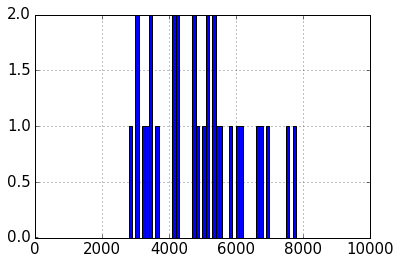

In [15]:
plt.rcParams.update({'font.size': 15})
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['njobs'].sum()
fig = a['njobs'].hist(bins=100, log=False, range=[0., 10000.])

## Events per task

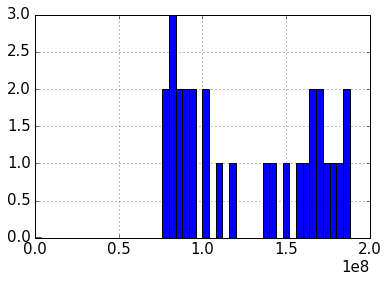

In [16]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['jevts'].sum()
fig = a['jevts'].hist(bins=50, range=[0., 2e8], log=False)

## Distribution of efficiency

In [17]:
grouped = df.groupby(['jeditaskid'], as_index=False)
a = grouped['eff'].sum()
a
#fig = a['eff'].hist(bins=150, log=False, range=(0, 1.5))   # NOT VERY CORRECT (arithmetic mean of efficiencies...)

,jeditaskid,eff
0,9002104,NaN
1,9002113,NaN
2,9002121,NaN
3,9002134,NaN
4,9002142,NaN
5,9002154,NaN
6,9002167,NaN
7,9002179,NaN
8,9002190,NaN
9,9002198,NaN


In the plot above, note the existence of efficiencies larger than 1! This has to be understood.

## Plot distribution of averages of CPU time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average CPU time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average CPU time per event.
Combinations consisting of merge jobs, of that account for less than 1.5% of the total wall-clock time, are ignored.

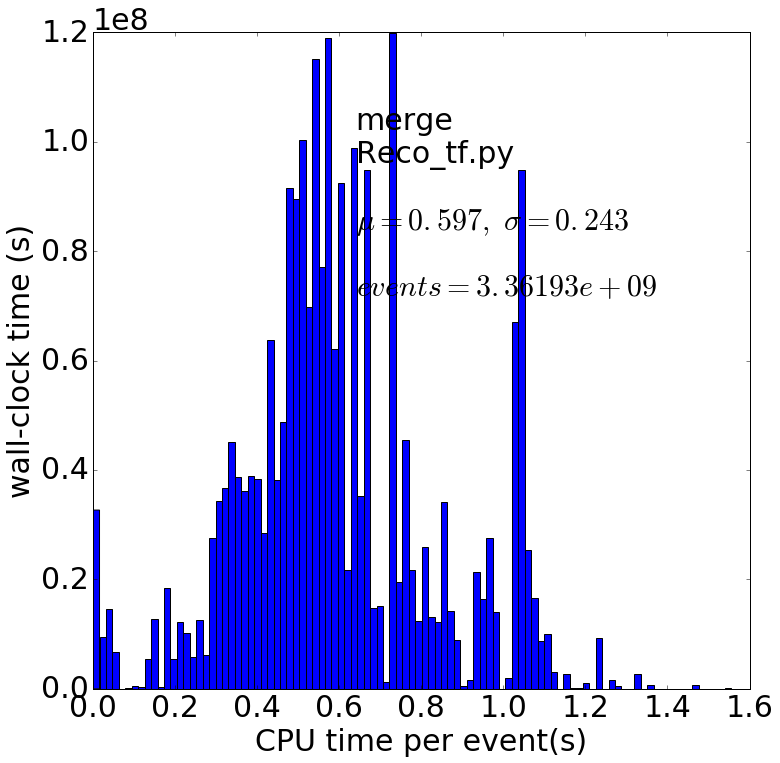

In [18]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'cpuevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 4., 10000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('CPU time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of wallclock time per event for tasks grouped by processingtype and transformation

The following plots show the distribution of the average wallclock time per event in tasks having the same processingtype and transformation. Therefore each histogram has a number of entries equal to the number of JEDI tasks for that combination.

The purpose of these plots is to show how much tasks of the same type can differ in terms of average wallclock time per event.

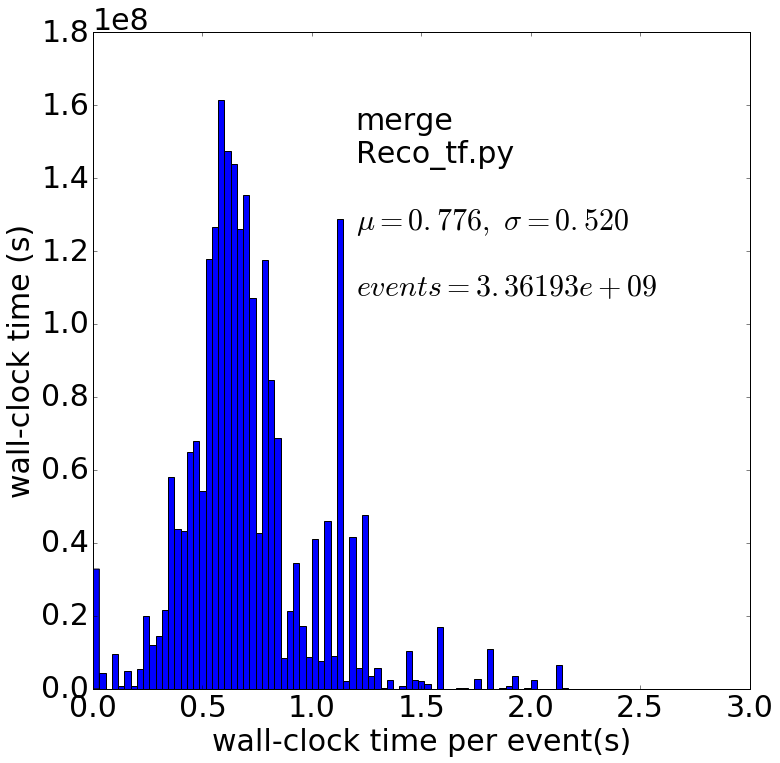

In [19]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'wallevt_avg'
log_scale = False
wc_tot = df['wc'].sum()
i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., min(mean + std * 4., 8000.)]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=log_scale)   # integral is total no. of events
    plt.xlabel('wall-clock time per event(s)')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    stats2 = r'$\mathit{events}=%g$' % g['jevts'].sum()
    if log_scale:
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.8, p+'\n'+t)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.7, stats)
        plt.text(t_x(.4), sp.get_ylim()[0] * (sp.get_ylim()[1] / sp.get_ylim()[0])**.6, stats2)
    else:
        plt.text(t_x(.4), t_y(.8), p+'\n'+t)
        plt.text(t_x(.4), t_y(.7), stats)
        plt.text(t_x(.4), t_y(.6), stats2)
    i += 1

## Plot distribution of averages of CPU efficiency per event for tasks grouped by processingtype and transformation

In [20]:
fig = plt.figure(figsize=(40,40))
plt.rcParams.update({'font.size': 30})
var = 'eff'
wc_tot = df['wc'].sum()
print ('Total wall-clock: %g s' % wc_tot)

i = 1

grouped = df.groupby(['processingtype', 'transformation'], as_index=False)

for (p, t), g in grouped:
    if i > 9: break
    if g['wc'].sum() < 0.015 * wc_tot:
        continue
    mean = np.average(g[var], weights=g['wc'])   # average time weighted with no. of events
    std = math.sqrt(np.average((g[var] - mean)**2, weights=g['wc']))
    range = [0., 1.]
    sp = plt.subplot(3, 3, i)
    plt.hist(g[var].tolist(), bins=100, range=range, weights=g['wc'].tolist(), log=False)   # integral is total no. of events
    plt.xlabel('CPU efficiency')
    plt.ylabel('wall-clock time (s)')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(.4), t_y(.8), p+'\n'+t)
    stats = r'$\mu=%.3f,\ \sigma=%.3f$' % (mean, std)
    plt.text(t_x(.4), t_y(.7), stats)
    stats = r'$\mathit{events}=%g$' % g['jevts'].sum()
    plt.text(t_x(.4), t_y(.6), stats)
    i += 1

Total wall-clock: 2.52258e+09 s


TypeError: Can't convert 'float' object to str implicitly

## Find tasks with a given efficiency

In [21]:
ptype = 'evgen'
trans = 'Generate_tf.py'
eff_range = [0.95, 1.]

tasks = list()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    if (p != ptype or t != trans): continue
    if re.search(r"merge", t, flags=re.IGNORECASE):
        continue
    mean = np.average(g['eff'], weights=g['jevts'])   # average time weighted with no. of events
    if eff_range[0] <= mean <= eff_range[1]:
        tasks.append(j)

In [22]:
print(tasks[:10])
df[df['jeditaskid'] == 9002104]

[]


,jeditaskid,processingtype,transformation,atlrel,site,njobs,cpuevt_avg,cpuevt_rms,wallevt_avg,wallevt_rms,cpu,wc,cores,jevts,eff
11,9002104,merge,Reco_tf.py,Atlas-20.7.6,BNL_PROD,1064,0.667217,0.166800,0.722793,0.180370,25055508.0,27136186.0,1.0,39732797.0,0.9233487516256268
44,9002104,merge,Reco_tf.py,Atlas-20.7.6,INFN-T1,546,0.586039,0.184343,0.637267,0.218589,11491519.0,12481535.0,1.0,21043014.0,0.927584360657751
76,9002104,merge,Reco_tf.py,Atlas-20.7.6,CERN-PROD,115,0.514270,0.181127,0.735145,0.289883,1693377.0,2457335.0,1.0,3391297.0,0.7462046358856981
82,9002104,merge,Reco_tf.py,Atlas-20.7.6,IN2P3-CC,474,0.599488,0.152260,0.615860,0.155014,8409715.0,8639877.0,1.0,14964154.0,0.9729374988981626
132,9002104,merge,Reco_tf.py,Atlas-20.7.6,LPC,359,0.815156,0.274927,1.067613,0.314860,7063802.0,9245932.0,1.0,8793417.0,0.7640972195725094
162,9002104,merge,Reco_tf.py,Atlas-20.7.6,CA-MCGILL-CLUMEQ-T2,28,0.355128,0.074005,0.405909,0.076341,415783.0,475270.0,1.0,1204510.0,0.8728660949995181
185,9002104,merge,Reco_tf.py,Atlas-20.7.6,DESY-HH_Condor,55,0.678591,0.267302,0.737332,0.271687,1066378.0,1163245.0,1.0,1618863.0,0.8987432559129475
211,9002104,merge,Reco_tf.py,Atlas-20.7.6,CSCS-LCG2,100,0.184936,0.142165,1.432174,1.065716,759659.0,8533944.0,1.0,2694420.0,0.08381493101306925
239,9002104,merge,Reco_tf.py,Atlas-20.7.6,RAL-LCG2_SL6,112,0.433255,0.136318,0.476724,0.150573,1845117.0,2077077.0,1.0,4067989.0,0.8616286527371627
271,9002104,merge,Reco_tf.py,Atlas-20.7.6,NIKHEF-ELPROD,78,0.413502,0.083880,0.435495,0.089201,1184820.0,1247815.0,1.0,2920017.0,0.9503556752452434


## Distribution of time/event for jobs inside a task

In [23]:
ptype = 'evgen'
trans = 'Generate_tf.py'

# Find JEDI task with given parameters
tot_evts = dict()
grouped = df.groupby(['processingtype', 'transformation', 'jeditaskid'], as_index=False)
for (p, t, j), g in grouped:
    tot_evts[j] = g['jevts'].sum()

biggest_tasks = sorted(tot_evts, key=tot_evts.get, reverse=True)
a = biggest_tasks[:100]
random_task = np.random.choice(a, 1)
print (random_task)

[9002331]


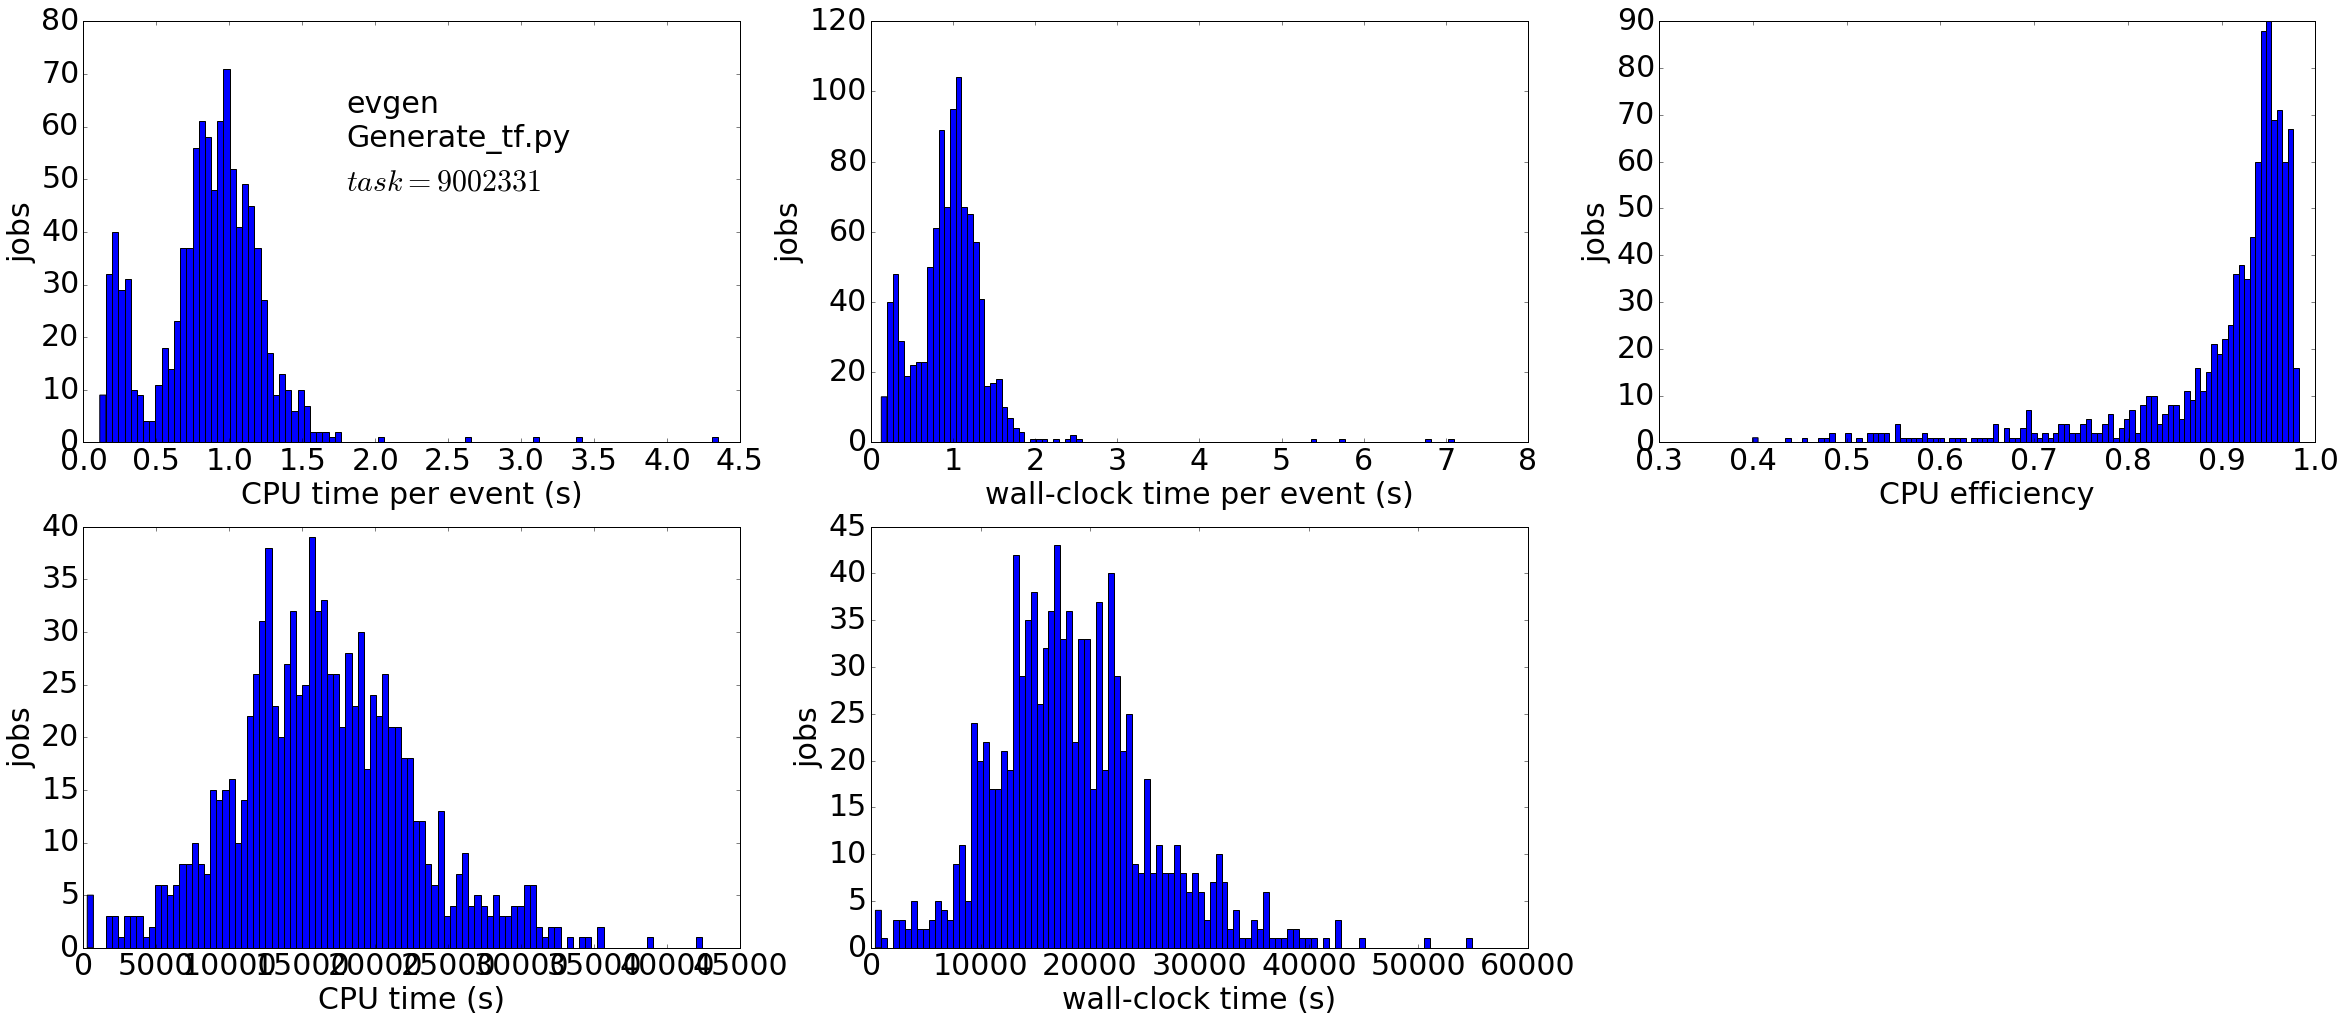

In [24]:
fig2 = plt.figure(figsize=(40,80))
plt.rcParams.update({'font.size': 30})
i = 1
for t in random_task:
    s = {
        "size": 1000,
        "_source": ["cpuconsumptiontime", "wall_time", "corecount", "nevents"],
        "query": {
            "filtered": {
                "filter": {
                    "bool": {
                        "must": [
                            { "match": { "jeditaskid": str(t)}},
                            { "range": {"nevents": {"gte": 1}}},
                            { "range": {"wall_time": {"gte": 60}}},
                            { "match": {"jobstatus": "finished"}}
                        ]
                    }
                }
            }
        }
    }
    res = es.search(index=ind, body=s, request_timeout=300)
    cputimes = list()
    wctimes = list()
    effs = list()
    cpus = list()
    wcs = list()
    for h in res['hits']['hits']:
        vars = h['_source']
        cpuevt = vars['cpuconsumptiontime'] / vars['nevents']
        wcevt = vars['wall_time'] * vars['corecount'] / vars['nevents']
        eff = vars['cpuconsumptiontime'] / vars['wall_time'] / vars['corecount']
        cpu = vars['cpuconsumptiontime']
        wc = vars['wall_time'] * vars['corecount']
        cputimes.append(cpuevt)
        wctimes.append(wcevt)
        effs.append(eff)
        cpus.append(cpu)
        wcs.append(wc)
    sp = plt.subplot(9, 3, i)
    plt.hist(cputimes, bins=100, range=None)
    plt.xlabel('CPU time per event (s)')
    plt.ylabel('jobs')
    t_x = lambda x: sp.get_xlim()[0] + (sp.get_xlim()[1] - sp.get_xlim()[0]) * x
    t_y = lambda x: sp.get_ylim()[0] + (sp.get_ylim()[1] - sp.get_ylim()[0]) * x
    plt.text(t_x(0.4), t_y(.7), ptype+'\n'+trans)
    stats = r'$task=%d$' % (t)
    plt.text(t_x(.4), t_y(.6), stats)
    sp = plt.subplot(9, 3, i+1)
    plt.hist(wctimes, bins=100, range=None)
    plt.xlabel('wall-clock time per event (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+2)
    plt.hist(effs, bins=100, range=None)
    plt.xlabel('CPU efficiency')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+3)
    plt.hist(cpus, bins=100, range=None)
    plt.xlabel('CPU time (s)')
    plt.ylabel('jobs')
    sp = plt.subplot(9, 3, i+4)
    plt.hist(wcs, bins=100, range=None)
    plt.xlabel('wall-clock time (s)')
    plt.ylabel('jobs')
    i += 5

## Examine a single task

See the distribution of the CPU time per event across different sites for a single task.

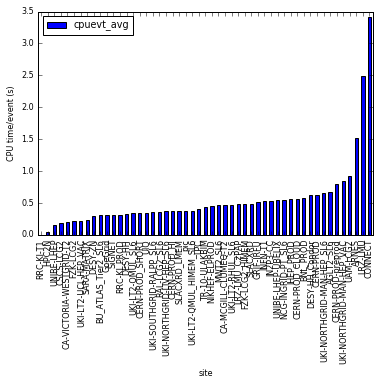

In [25]:
taskid = 9002104
dfx = df[df['jeditaskid'] == taskid]
df2 = dfx.groupby('site').aggregate({'cpuevt_avg': np.mean})
plt.rcParams.update({'font.size': 8})
plt.figure()
df2.sort_values('cpuevt_avg').plot.bar()
plt.ylabel('CPU time/event (s)')

## Distribution of average CPU time per event across different sites for a given task

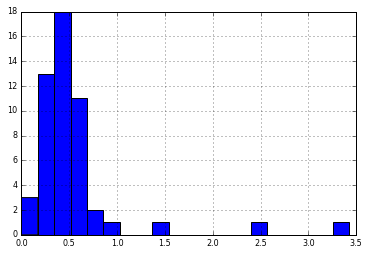

In [26]:
df2['cpuevt_avg'].hist(bins=20)

## Analyse all tasks

Study the spread in the CPU time per event on different sites.

In [27]:
ptype = 'pile'
k = list()
ns = list()
grouped = df.groupby(['jeditaskid', 'site'], as_index=False)
g = grouped['cpuevt_avg'].agg(np.mean)
tasks = g['jeditaskid'].unique()
for t in tasks:
    g2 = g[g.jeditaskid == t]
    n = len(g2)
    ns.append(n)
    if len(g2) < 3: continue
    avg = g2['cpuevt_avg'].mean()   # wrong: mean not weighted
    std = g2['cpuevt_avg'].std()   # wrong: mean not weighted
    if np.isnan(std): continue
    try:
        ratio = std / avg
        k.append(ratio)
    except:
        continue

### Distribution of number of sites used by a task

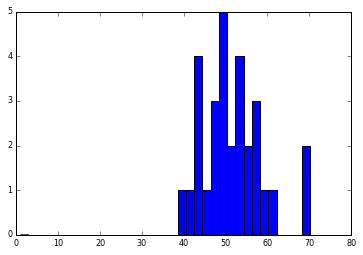

In [28]:
fig = plt.hist(ns, bins=40, range=(1, 80))

### Distribution of the normalised spread of the CPU time per event across different sites

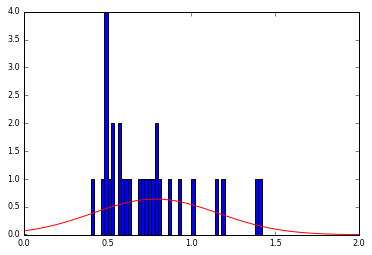

In [29]:
bins = 100
range = (0, 2)
n = len(k)
mu = np.mean(k)
sigma = np.std(k)
fig = plt.hist(k, bins=bins, range=range)
binsize = (range[1] - range[0]) / bins
plt.plot(fig[1], n * binsize/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (fig[1] - mu)**2 / (2 * sigma**2)), color='r')

## Ranking of sites by wall-clock

In [30]:
grouped = df.groupby(['site'], as_index=False)
tot_wc = grouped['wc'].sum()
a = tot_wc.sort_values('wc', ascending=False)
bigtotal_wc = a.wc.sum()
a[a.wc > bigtotal_wc * 0.001].site.tolist()

['BNL_PROD',
 'INFN-T1',
 'CSCS-LCG2',
 'IN2P3-CC',
 'CERN-PROD',
 'LPC',
 'FZK-LCG2',
 'DESY-HH_Condor',
 'CA-MCGILL-CLUMEQ-T2',
 'RAL-LCG2_SL6',
 'NIKHEF-ELPROD',
 'FZK-LCG2_HIMEM',
 'MWT2_SL6',
 'UKI-LT2-QMUL_HIMEM_SL6',
 'CERN-PROD_SHORT',
 'UIO',
 'SARA-MATRIX',
 'DESY-HH',
 'SiGNET',
 'HPC2N',
 'GRIF-LPNHE',
 'MWT2_HIMEM',
 'CONNECT',
 'LAPP',
 'CERN-PROD-preprod',
 'UKI-SOUTHGRID-RALPP_SL6',
 'DESY-ZN',
 'GRIF-IRFU',
 'CERN-PROD_HI',
 'BU_ATLAS_Tier2_SL6',
 'AGLT2_SL6',
 'IN2P3-LPSC',
 'GoeGrid',
 'UKI-NORTHGRID-LIV-HEP_SL6',
 'UKI-LT2-QMUL_SL6',
 'NCG-INGRID-PT_SL6',
 'NSC',
 'TRIUMF',
 'RRC-KI-T1',
 'INFN-FRASCATI',
 'AGLT2_LMEM',
 'GRIF-LAL_HTCondor',
 'UNIBE-LHEP',
 'UNI-FREIBURG',
 'LRZ-LMU_C2PAP',
 'UKI-NORTHGRID-LANCS-HEP_SL6',
 'UKI-LT2-RHUL_SL6',
 'Taiwan-LCG2_VL',
 'LRZ-LMU',
 'Taiwan-LCG2',
 'CPPM',
 'UNIBE-LHEP-UBELIX',
 'ARNES',
 'IFAE',
 'UKI-SCOTGRID-ECDF_SL6',
 'SLACXRD_LMEM',
 'SFU-LCG2',
 'UKI-NORTHGRID-MAN-HEP_VAC',
 'SLACXRD',
 'INFN-NAPOLI-RECAS',
 'UKI-SCOT